<a href="https://colab.research.google.com/github/Uditsingh7/Deep_Learning_Projects/blob/main/Udit_Text_Classification_Transformers.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# @title 1. Initializations and Dataset Download

!pip install transformers --quiet
!pip install opendatasets --quiet
import opendatasets as od
od.download("https://www.kaggle.com/datasets/rmisra/news-headlines-dataset-for-sarcasm-detection")

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: uditsinghthakur
Your Kaggle Key: ··········
Dataset URL: https://www.kaggle.com/datasets/rmisra/news-headlines-dataset-for-sarcasm-detection


100%|██████████| 3.30M/3.30M [00:00<00:00, 848MB/s]

In [2]:
# @title 2. Imports

import torch  # Core PyTorch library for tensor computations and automatic differentiation
import torch.nn as nn  # Contains neural network layers and functions like Conv2d, Linear, ReLU
from torch.optim import Adam  # Adam optimizer: adaptive learning rate optimizer for faster training
from transformers import AutoTokenizer, AutoModel
# Hugging Face utilities to load pretrained tokenizers and models easily by name (e.g., BERT)

from torch.utils.data import Dataset, DataLoader
# Dataset defines data access; DataLoader creates batches, handles shuffling during training

from sklearn.model_selection import train_test_split
# Splits dataset into training and test sets for fair model evaluation

from sklearn.metrics import accuracy_score
# Computes classification accuracy: correct predictions / total samples

import matplotlib.pyplot as plt
# Plotting library to visualize training progress (loss, accuracy graphs)

import pandas as pd
# Data handling library for structured/tabular data (CSV, Excel, etc.)

import numpy as np
# Numerical computing library for fast array operations and math functions


# Select device for computation: GPU if available, else CPU
device = 'cuda' if torch.cuda.is_available() else 'cpu'

print("Available Device is: ", device)  # Print which device will be used for model training/inference


Available Device is:  cuda


In [3]:
# @title 3. Dataset

data_df = pd.read_json("/content/news-headlines-dataset-for-sarcasm-detection/Sarcasm_Headlines_Dataset.json", lines=True)
data_df.dropna(inplace=True)
print(data_df.shape)
data_df.head()

(26709, 3)


,article_link,headline,is_sarcastic
0,https://www.huffingtonpost.com/entry/versace-b...,former versace store clerk sues over secret 'b...,0
1,https://www.huffingtonpost.com/entry/roseanne-...,the 'roseanne' revival catches up to our thorn...,0
2,https://local.theonion.com/mom-starting-to-fea...,mom starting to fear son's web series closest ...,1
3,https://politics.theonion.com/boehner-just-wan...,"boehner just wants wife to listen, not come up...",1
4,https://www.huffingtonpost.com/entry/jk-rowlin...,j.k. rowling wishes snape happy birthday in th...,0


In [4]:
# @title 4. Data Splitting

X_train, X_test, y_train, y_test = train_test_split(np.array(data_df['headline']), np.array(data_df['is_sarcastic']), test_size=0.3)

X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5)

In [5]:
print("Training set is: ", X_train.shape[0], " rows which is ", round(X_train.shape[0]/data_df.shape[0],4)*100, "%")
print("Validation set is: ",X_val.shape[0], " rows which is ", round(X_val.shape[0]/data_df.shape[0],4)*100, "%")
print("Testing set is: ",X_test.shape[0], " rows which is ", round(X_test.shape[0]/data_df.shape[0],4)*100, "%")

Training set is:  18696  rows which is  70.0 %
Validation set is:  4006  rows which is  15.0 %
Testing set is:  4007  rows which is  15.0 %


In [6]:
# @title 5. Download Model and tokenizer

tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")
bert_model = AutoModel.from_pretrained("bert-base-uncased")

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

In [7]:
# @title 6. Dataset Object
# Define a new class named 'dataset' that inherits from PyTorch's Dataset class
# A class is a blueprint to create objects with attributes (variables) and methods (functions)
class dataset(Dataset):

    # The __init__ method is the constructor, called when you create an instance of this class
    # 'self' represents the instance itself, allowing access to its attributes and methods
    def __init__(self, X, Y):
        # Tokenize each input text 'x' in X:
        # - max_length=100 limits tokenized length to 100 tokens
        # - truncation=True cuts longer sequences to max_length
        # - padding='max_length' pads shorter sequences to max_length
        # - return_tensors='pt' returns PyTorch tensors
        # Then move tokenized inputs to the device (CPU or GPU)
        self.X = [tokenizer(x,
                            max_length=100,
                            truncation=True,
                            padding='max_length',
                            return_tensors='pt').to(device)
                  for x in X  # Iterate over all texts in X
                 ]

        # Convert labels Y to a PyTorch tensor of type float32 and move to device
        self.Y = torch.tensor(Y, dtype=torch.float32).to(device)

    # __len__ method returns the number of samples in the dataset
    # This is used by PyTorch DataLoader to know dataset size
    def __len__(self):
        return len(self.X)

    # __getitem__ returns a single sample (input, label) at the given index
    # This is used to fetch data during training in batches
    def __getitem__(self, index):
        return self.X[index], self.Y[index]


# Create instances of the dataset class for training, validation, and testing datasets
# Each instance will contain tokenized inputs and corresponding labels moved to device
training_data = dataset(X_train, y_train)
validation_data = dataset(X_val, y_val)
testing_data = dataset(X_test, y_test)





In [15]:
# @title 7. Training Hyper Parameters
BATCH_SIZE = 32
EPOCHS = 10
LR = 1e-4


In [9]:
# @title 8. Data Loaders

train_dataloader = DataLoader(training_data, batch_size=BATCH_SIZE, shuffle= True)
validation_dataloader = DataLoader(validation_data, batch_size=BATCH_SIZE, shuffle= True)
testing_dataloader = DataLoader(testing_data, batch_size=BATCH_SIZE, shuffle= True)

In [11]:
# @title 9. Model Class

# Define a custom neural network model class by extending PyTorch's nn.Module
# Why this class? To combine a pretrained BERT model with additional layers for a specific task,
# like binary classification, in a modular and reusable way.
class MyModel(nn.Module):

    # __init__ is the constructor method called when creating an instance of this model class.
    # 'self' refers to the instance being created, 'bert' is the pretrained BERT model passed as input.
    def __init__(self, bert):

        # Call the constructor of the parent nn.Module class to properly initialize the model
        super(MyModel, self).__init__()

        # Store the passed BERT model as a member variable to use in forward pass
        self.bert = bert

        # Dropout layer randomly zeros out 25% of neurons during training
        # Helps prevent overfitting by regularizing the network
        self.dropout = nn.Dropout(0.25)

        # Linear (fully connected) layer that reduces BERT's 768-dimensional output to 384
        # This learns a new representation tailored to the task
        self.linear1 = nn.Linear(768, 384)

        # Another Linear layer that reduces 384 features down to 1 output unit
        # Suitable for binary classification output (e.g., probability of class 1)
        self.linear2 = nn.Linear(384, 1)

        # Sigmoid activation squashes the output between 0 and 1, representing probability
        self.sigmoid = nn.Sigmoid()

    # The forward method defines the computation performed at every call
    # It describes how input data flows through the model layers
    # input_ids and attention_mask are inputs required by BERT to process text data
    def forward(self, input_ids, attention_mask):

        # Pass inputs through BERT; return_dict=False returns outputs as a tuple
        # We take the first token's embedding ([CLS] token) for classification, located at [:,0]
        pooled_output = self.bert(input_ids, attention_mask, return_dict=False)[0][:, 0]

        # Pass BERT output through first linear layer to reduce dimensions
        output = self.linear1(pooled_output)

        # Apply dropout for regularization
        output = self.dropout(output)

        # Pass through second linear layer to get a single output value
        output = self.linear2(output)

        # Apply sigmoid to get a probability between 0 and 1 for binary classification
        output = self.sigmoid(output)

        # Return the final prediction
        return output


In [13]:
# @title 10. Pretraining
# Freeze all the parameters of the pretrained BERT model
# 'parameters()' returns all weights and biases of bert_model
for param in bert_model.parameters():
    param.requires_grad = False  # Prevent these parameters from being updated during training
    # Why? Freezing BERT saves computation and avoids changing its learned knowledge,
    # especially useful when dataset is small or fine-tuning only the added layers.

# Create an instance of the custom model MyModel, passing the frozen BERT model
model = MyModel(bert_model).to(device)  # Move the model to the GPU or CPU based on availability
# Why? Moving to device enables faster computation and compatibility with your data tensors.



In [14]:
# @title 11. Loss and Optimizer

# Define the loss function as Binary Cross Entropy Loss
# BCELoss is used for binary classification tasks where output is a probability between 0 and 1
criterion = nn.BCELoss()
# Why? It measures the difference between predicted probabilities and true binary labels,
# penalizing incorrect predictions more when they are confident but wrong.

# Define the optimizer as Adam to update model parameters during training
# Pass all model parameters (including added layers) to Adam optimizer
optimizer = Adam(model.parameters(), lr=LR)
# Why Adam? It adapts the learning rate for each parameter, often leading to faster convergence
# 'lr' sets the initial learning rate, controlling step size during optimization


**Backpropagation** is the process by which a neural network learns.

After the model makes a prediction, we calculate a loss — how far off the prediction is from the true answer.

To improve, the model needs to know how to change its parameters (weights and biases) to reduce this loss.

Computing gradients of the loss with respect to the model parameters means calculating the direction and magnitude of change needed for each parameter to decrease the loss.

This is done using calculus (chain rule) behind the scenes.

In PyTorch, calling loss.backward() triggers this gradient computation step automatically.

These gradients are then used by the optimizer (like Adam) to update the model’s parameters in the right direction

In [16]:
# @title 12. Training Loop

# Lists to store average loss and accuracy values for each epoch
total_loss_train_plot = []        # Training loss history (for plotting/analysis)
total_loss_validation_plot = []   # Validation loss history
total_acc_train_plot = []         # Training accuracy history (%)
total_acc_validation_plot = []    # Validation accuracy history (%)

# Loop over the total number of epochs to train the model
for epoch in range(EPOCHS):
    # Initialize accumulators for this epoch to sum losses and correct predictions
    total_acc_train = 0    # Count of correct predictions on training data
    total_loss_train = 0   # Sum of training losses
    total_acc_val = 0      # Count of correct predictions on validation data
    total_loss_val = 0     # Sum of validation losses

    ## Training phase: iterate over batches from training dataloader
    for indx, data in enumerate(train_dataloader):
        input, label = data  # Unpack batch data: 'input' is dict of tokenized text tensors, 'label' is ground truth

        # Move input tensors and labels to the GPU or CPU (device) for computation
        input.to(device)
        label.to(device)

        # Forward pass: feed input tensors through the model
        # Squeeze(1) removes extra dimension of size 1 (common in tokenized inputs)
        prediction = model(input['input_ids'].squeeze(1),
                           input['attention_mask'].squeeze(1)).squeeze(1)  # Final output shape: batch_size

        # Calculate loss comparing predicted probabilities with true labels
        batch_loss = criterion(prediction, label)

        # Accumulate training loss as a scalar
        total_loss_train += batch_loss.item()

        # Calculate number of correct predictions by rounding predictions to 0 or 1
        acc = ((prediction).round() == label).sum().item()
        total_acc_train += acc

        # Backpropagation: compute gradients of loss w.r.t. model parameters
        batch_loss.backward()

        # Update model parameters using optimizer (Adam)
        optimizer.step()

        # Reset gradients to zero before next batch
        optimizer.zero_grad()

    ## Validation phase: no gradient computation for efficiency and correctness
    with torch.no_grad():
        for indx, data in enumerate(validation_dataloader):
            input, label = data
            input.to(device)
            label.to(device)

            # Forward pass on validation data
            prediction = model(input['input_ids'].squeeze(1),
                               input['attention_mask'].squeeze(1)).squeeze(1)

            # Compute validation loss
            batch_loss_val = criterion(prediction, label)
            total_loss_val += batch_loss_val.item()

            # Count correct predictions in validation batch
            acc = ((prediction).round() == label).sum().item()
            total_acc_val += acc

    # Append averaged losses (scaled down) to the plot lists for visualization later
    total_loss_train_plot.append(round(total_loss_train / 1000, 4))
    total_loss_validation_plot.append(round(total_loss_val / 100, 4))

    # Calculate accuracy percentages by dividing total correct by dataset size
    total_acc_train_plot.append(round(total_acc_train / training_data.__len__() * 100, 4))
    total_acc_validation_plot.append(round(total_acc_val / validation_data.__len__() * 100, 4))

    # Print summary of this epoch's performance
    print(f'''Epoch no. {epoch + 1} Train Loss: {total_loss_train / 1000:.4f} Train Accuracy: {(total_acc_train / training_data.__len__() * 100):.4f} Validation Loss: {total_loss_val / 100:.4f} Validation Accuracy: {(total_acc_val / validation_data.__len__() * 100):.4f}''')
    print("=" * 50)


Epoch no. 1 Train Loss: 0.2600 Train Accuracy: 80.0760 Validation Loss: 0.4988 Validation Accuracy: 83.8992
Epoch no. 2 Train Loss: 0.2100 Train Accuracy: 84.4673 Validation Loss: 0.4504 Validation Accuracy: 84.9975
Epoch no. 3 Train Loss: 0.1977 Train Accuracy: 85.4621 Validation Loss: 0.4342 Validation Accuracy: 85.2971
Epoch no. 4 Train Loss: 0.1910 Train Accuracy: 85.8365 Validation Loss: 0.4239 Validation Accuracy: 85.6216
Epoch no. 5 Train Loss: 0.1868 Train Accuracy: 86.2537 Validation Loss: 0.4318 Validation Accuracy: 84.9975
Epoch no. 6 Train Loss: 0.1845 Train Accuracy: 86.3072 Validation Loss: 0.4197 Validation Accuracy: 86.3954
Epoch no. 7 Train Loss: 0.1826 Train Accuracy: 86.5265 Validation Loss: 0.4130 Validation Accuracy: 86.5452
Epoch no. 8 Train Loss: 0.1800 Train Accuracy: 86.6068 Validation Loss: 0.4162 Validation Accuracy: 86.1208
Epoch no. 9 Train Loss: 0.1782 Train Accuracy: 86.8314 Validation Loss: 0.4071 Validation Accuracy: 86.3954
Epoch no. 10 Train Loss: 0.1

In [17]:
# @title 13. Testing

# Disable gradient calculations to save memory and computation during evaluation
with torch.no_grad():
    total_loss_test = 0  # Initialize total test loss accumulator
    total_acc_test = 0   # Initialize total correct predictions counter

    # Iterate over batches in the test dataset loader
    for indx, data in enumerate(testing_dataloader):
        input, label = data  # Unpack batch inputs and true labels

        # Move inputs and labels to the device (GPU or CPU) for computation
        input.to(device)
        label.to(device)

        # Forward pass through the model with squeezed input tensors
        prediction = model(input['input_ids'].squeeze(1), input['attention_mask'].squeeze(1)).squeeze(1)

        # Calculate loss for the current batch using the criterion function
        batch_loss_val = criterion(prediction, label)

        # Accumulate the batch loss value (converted to a standard Python float)
        total_loss_test += batch_loss_val.item()

        # Calculate number of correct predictions by rounding model outputs and comparing to labels
        acc = ((prediction).round() == label).sum().item()
        total_acc_test += acc

# Calculate and print the overall accuracy percentage on the test set
print(f"Accuracy Score is: {round((total_acc_test / X_test.shape[0]) * 100, 2)}%")


Accuracy Score is: 86.1%


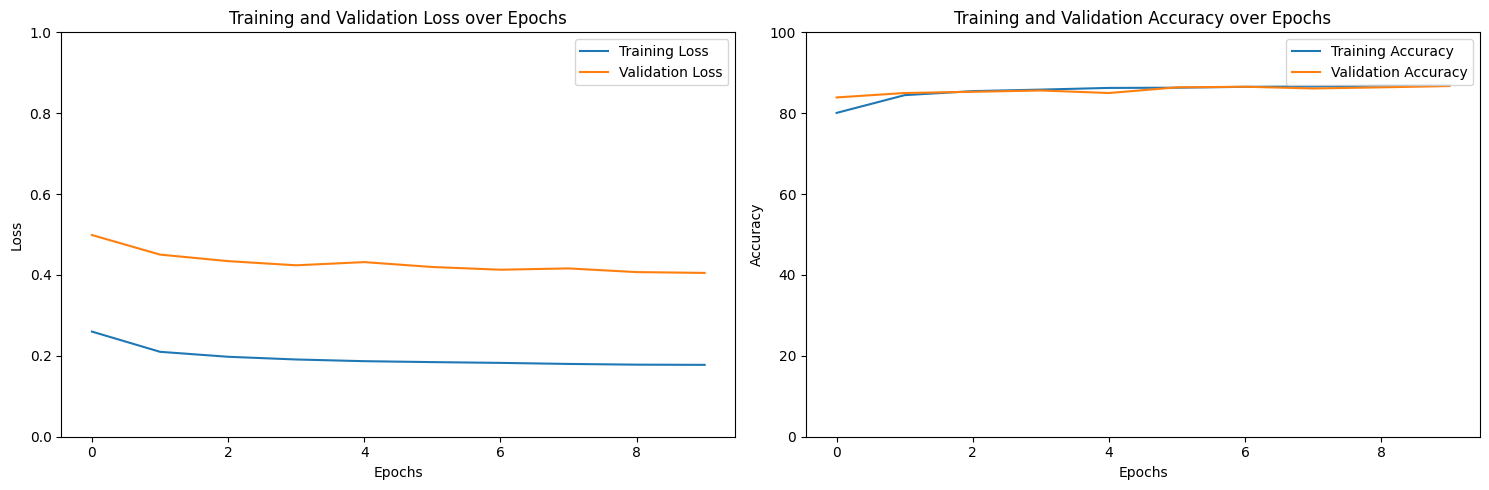

In [18]:
# @title 14. Plotting and Visualizations

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

axs[0].plot(total_loss_train_plot, label='Training Loss')
axs[0].plot(total_loss_validation_plot, label='Validation Loss')
axs[0].set_title('Training and Validation Loss over Epochs')
axs[0].set_xlabel('Epochs')
axs[0].set_ylabel('Loss')
axs[0].set_ylim([0, 1])
axs[0].legend()

axs[1].plot(total_acc_train_plot, label='Training Accuracy')
axs[1].plot(total_acc_validation_plot, label='Validation Accuracy')
axs[1].set_title('Training and Validation Accuracy over Epochs')
axs[1].set_xlabel('Epochs')
axs[1].set_ylabel('Accuracy')
axs[1].set_ylim([0, 100])
axs[1].legend()

plt.tight_layout()

plt.show()
